In [1]:
import pandas as pd
import numpy as np
import PreProcessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
df = pd.read_csv('energydata_complete.csv')
test = PreProcessing.PreProcessing(df, 'Appliances')
test.clean(['index', 'date','rv1','rv2','T9','T6','Windspeed'])
test.shift(1,1)
df = test.data

In [3]:
df.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_7(t-1),T8(t-1),RH_8(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
0,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,45.53,6.600000,733.5,92.0,63.000000,5.3,60
1,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,45.56,6.483333,733.6,92.0,59.166667,5.2,50
2,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,45.50,6.366667,733.7,92.0,55.333333,5.1,50
3,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,45.40,6.250000,733.8,92.0,51.500000,5.0,60
4,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,45.40,6.133333,733.9,92.0,47.666667,4.9,50


In [9]:
test.get_train_test_normalized(0.75, 'Appliances(t)')
X_train, X_test, y_train, y_test = test.X_train, test.X_test, test.y_train, test.y_test
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14800, 23) (14800, 1) (4934, 23) (4934, 1)


Para a LSTM

In [10]:
test.reshape_LSTM()
X_train, X_test, y_train, y_test = test.X_train, test.X_test, test.y_train, test.y_test
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14800, 1, 23) (14800, 1) (4934, 1, 23) (4934, 1)


In [11]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras import regularizers
# design network
neurons = 50
batch_size = 32
epochs = 25
model = Sequential()
model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [12]:
# design network
from keras.callbacks import EarlyStopping
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activity_regularizer=regularizers.l2(10e-5),
               activation='relu', kernel_regularizer=regularizers.l1(10e-5), recurrent_regularizer = regularizers.l2(10e-5)))
model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, activation='relu'))
#model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, activation='relu'))
#model.add(LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2]))) 
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam',metrics=['mse'])
es = EarlyStopping(monitor='mse', mode='min', verbose=1, patience=30)

Epoch 1/25
417/417 [==============================] - 10s 8ms/step - loss: 0.0963 - mse: 0.0755 - val_loss: 0.0129 - val_mse: 0.0089
Epoch 2/25
417/417 [==============================] - 2s 4ms/step - loss: 0.0114 - mse: 0.0080 - val_loss: 0.0068 - val_mse: 0.0047
Epoch 3/25
417/417 [==============================] - 1s 3ms/step - loss: 0.0064 - mse: 0.0046 - val_loss: 0.0053 - val_mse: 0.0041
Epoch 4/25
417/417 [==============================] - 3s 6ms/step - loss: 0.0054 - mse: 0.0043 - val_loss: 0.0049 - val_mse: 0.0041
Epoch 5/25
417/417 [==============================] - 3s 7ms/step - loss: 0.0050 - mse: 0.0043 - val_loss: 0.0047 - val_mse: 0.0041
Epoch 6/25
417/417 [==============================] - 1s 3ms/step - loss: 0.0049 - mse: 0.0043 - val_loss: 0.0046 - val_mse: 0.0041
Epoch 7/25
417/417 [==============================] - 3s 7ms/step - loss: 0.0048 - mse: 0.0043 - val_loss: 0.0046 - val_mse: 0.0041
Epoch 8/25
417/417 [==============================] - 2s 6ms/step - loss: 0

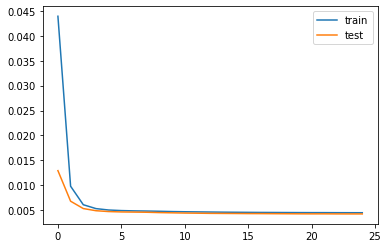

In [13]:
# fit network
import matplotlib.pyplot as plt
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1,  shuffle=False)
# plot history
plt.clf()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig('loss.png')
plt.close('all')

In [14]:
yhat = model.predict(X_test)
y_test, y_pred = test.inverse_LSTM(yhat)

In [15]:
from pyFTS.benchmarks import Measures
rmse = Measures.rmse(y_test, y_pred)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 68.154
